# MNIST推理
MNIST是手写数字识别，数据集有60000个训练样本和10000个测试样本，这些图像可以用于学习（训练）和推理（验证）。一般使用方法是，先用训练图像进行学习，在用学习到的模型度量能在多大程度上对测试图像进行正确的分类。

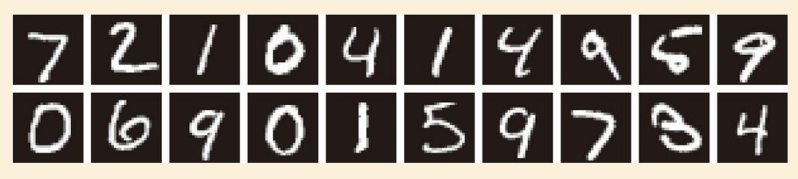

MNIST的图像数据是28x28的灰度图，每个像素点用0-255的整数表示。
训练集和测试集（图像和标签）都已经保存在dataset目录下，加载数据库的代码已经放在该目录下的mnist.py文件中。该代码文件中的load_mnist()函数可以读入MNIST数据，并采用pickle格式保存为二进制文件。

假设训练过程已经完成，现在使用学习到的参数，实现神经网络的“推理处理”，即向前传播（forward propagation）。

## 加载和构建数据集

In [8]:
import sys, os
from dataset.mnist import load_mnist
import numpy as np

In [4]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normolize=False)

# 输出各个数据的形状
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

Converting train-images-idx3-ubyte.gz to Numpy array ...
Done!
Converting train-labels-idx1-ubyte.gz to Numpy array ...
Done!
Converting t10k-images-idx3-ubyte.gz to Numpy array ...
Done!
Converting t10k-labels-idx1-ubyte.gz to Numpy array ...
Done!
Create pickle file ...
Done!
Loading dataset ...
(60000, 784)
(60000,)
(10000, 784)
(10000,)


使用matplotlib，显示数据集中的图像。也可以使用PIL，将图像数组转换为图像，或显示或保存。

5
(784,)
(28, 28)


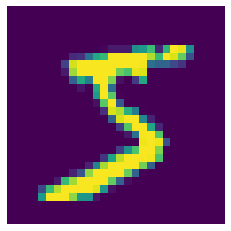

In [14]:
import matplotlib.pyplot as plt

def show_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

img = x_train[0]
label = t_train[0]
print(label)
print(img.shape)
img = img.reshape(28, 28)
print(img.shape)
show_image(img)

## 神经网络的推理处理

MNIST数据集形成的神经网络，输入层有784（28×28）个神经元，输出层有10（0-9）个神经元。此外，这个网络还有两个隐藏层，第1个隐藏层有50个神经元，第2个隐藏层有100个神经元（50和100可以设置为任何值）。

接下来，创建neuralnet_mnist.py文件，包含3个函数：
- get_data()：获取测试集（图像和标签）。
- init_network()：初始化神经网络，读入保存在pickle文件sample_weight.pkl中的权重和偏置。
- predict()：使用神经网络进行推理处理，返回预测结果。

利用这三个函数来实现神经网络的推理处理，然后评价他的识别精度，即能在测试集中识别出正确率多少。

In [16]:
import pickle
from common.functions import sigmoid, softmax

def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normolize=True, flatten=True, one_hot_label=False)
    return x_test, t_test

def init_network():
    with open('./dataset/sample_weight.pkl', 'rb') as f:
        network = pickle.load(f)
    
    return network

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y

首先获得MNIST测试数据集，生成网络模型，然后通过for循环预测数据集中的每个数字。获取结果y中数值最大（概率最大）的索引，作为预测结果。如果预测结果与真实值相同，则预测正确，accuray_cnt加1。

In [17]:
x,t = get_data()
network = init_network()

accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])
    p = np.argmax(y) # 获取概率最大的那个数字，即概率最高的元素的索引。
    if p == t[i]:
        accuracy_cnt += 1

print("Accuracy: " + str(float(accuracy_cnt) / len(x)))

Loading dataset ...
Accuracy: 0.9352


以上代码中，把load_mnist函数的参数normalize设置为True后，函数内部就会进行转换，将图像的各个像素值除以255，这样就可以把图像的像素值限制在0~1之间。像这样把数据限定到某个范围内的处理称为**正则化（normalization）**。
此外，神经网络的输入数据进行某种既定的转换成为**预处理（pre-processing）**。
将数据整体的分布形状均匀化，即**数据白化（whitening）**。

## 批处理

观察输入数据和权重参数的形状。

In [18]:
x, _ = get_data()
network = init_network()
W1, W2, W3 = network['W1'], network['W2'], network['W3']
print('x', x.shape)
print('x0', x[0].shape)
print('W1: ', W1.shape)
print('W2: ', W2.shape)
print('W3: ', W3.shape)

Loading dataset ...
x (10000, 784)
x0 (784,)
W1:  (784, 50)
W2:  (50, 100)
W3:  (100, 10)


观察结果，多维数组的对应维度的元素个数是一致的，这只是输入一张图像时的处理流程。

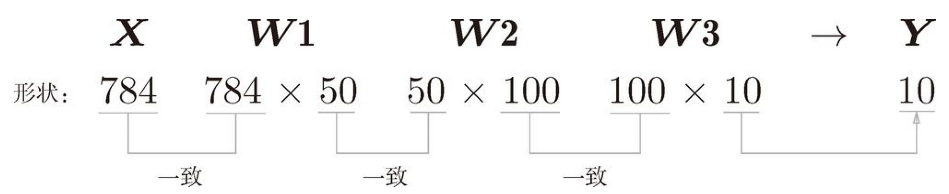

假设，我们一次性打包处理100张图像，那么输入的形状应该是[100, 28, 28]，即100 × 28 × 28。

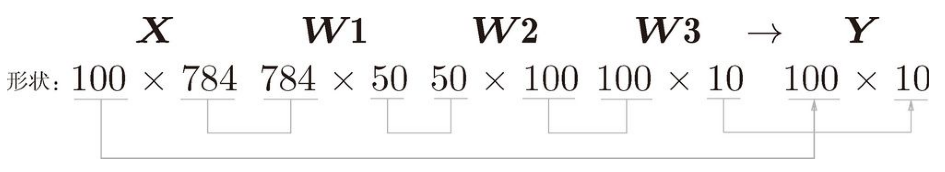

这种打包式的输入数据称为**批处理（batch）**。

In [19]:
x, t = get_data()
network = init_network()

batch_size = 100
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i: i + batch_size]
    y_batch = predict(network, x_batch)
    p = np.argmax(y_batch, axis=1) 
    accuracy_cnt += np.sum(p == t[i: i + batch_size])

print("Accuracy: {:.2f}%".format(100 * accuracy_cnt / len(x)))


Loading dataset ...
Accuracy: 93.52%


axis=1 的目的是以列查找的方式得到每一行的最大值，因为y_batch是二维数组，为了比较每行数据，所以axis=1。
关于axis = 1的问题，可以参考一下示例。

In [23]:
x = np.array([[0.1, 0.8, 0.1], [0.6, 0.2, 0.5], [0.9, 0.2, 0.7], [0.1, 0.5, 0.9]])
y = np.argmax(x, axis=1)
print(y)

[1 0 0 2]


In [25]:
x = np.array([1,2,3])
y = np.array([3,2,1])
print(x==y)
print(np.sum(y==x))

[False  True False]
1
